<a href="https://colab.research.google.com/github/nisanuro/CNG483-Assignment1/blob/master/CNG483_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [261]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Function for reading the images from the file. It returns a image list.

In [0]:
def readImages(path):
    images = []

    for filename in os.listdir(path):
        img=cv2.imread(os.path.join(image_path, filename),cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        images.append(img)

    return images

Function for applying Gray World Algorithm, a white balance algorithm, to the images.

In [0]:
def grayWorld(img):
    b,g,r = cv2.split(img)

    b = b + (b / b.mean().mean()).astype(np.uint8)
    g = g + (g / g.mean().mean()).astype(np.uint8)
    r = r + (r / r.mean().mean()).astype(np.uint8)

    img = cv2.merge((b,g,r))

    return img

Function for displaying the histograms of the images in order to make a skin color assumption.

In [0]:
def displayHistogram(img):
    color = ('b','g','r')

    for i,col in enumerate(color):
        histr = cv2.calcHist([img],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
    plt.show()

Function for segmentation using RGB color space.

In [0]:
def thresholdRGB(img):
    # First of all, applied gray world algorithm
    gw_img = grayWorld(img)

    # Remember -> OpenCV uses BGR order
    # Ranges for skin color
    lowerBound = (80,60,25)
    upperBound = (120,110,140)

    # In order to create more efficient mask, applied gaussian filter.
    gw_img = cv2.GaussianBlur(gw_img, (7,7), 0)
    
    # Created the mask using the threshold
    mask = cv2.inRange(gw_img, lowerBound, upperBound);
    
    # Applied dilation to increase size of foreground object
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, np.ones((3,3),np.uint8))

    # Applied mask to the image
    result = cv2.bitwise_and(gw_img, gw_img, mask = mask)

    # Created a binary image
    result[np.all(result != 0, axis=-1)] = [255, 255, 255]


    plt.suptitle("RGB Color Space", fontsize = 14)
    plt.subplot(1, 4, 1)
    plt.title('Original'); plt.xticks([]); plt.yticks([])
    plt.imshow(img)
    plt.subplot(1, 4, 2)
    plt.title('Gray World'); plt.xticks([]); plt.yticks([])
    plt.imshow(gw_img)
    plt.subplot(1, 4, 3)
    plt.title('Mask'); plt.xticks([]); plt.yticks([])
    plt.imshow(mask)
    plt.subplot(1, 4, 4)
    plt.title('Result'); plt.xticks([]); plt.yticks([])
    plt.imshow(result)
    plt.show()


Function for segmentation using YCrCb color space.\
I used range that I found during my research:\
75 < Cr < 125\
130 < Cb < 170

In [0]:
def thresholdYCRCB(img):
    # Converted RGB image to YCrCb
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

    # Applied gray world algorithm
    gw_img = grayWorld(img)

    # In order to create more efficient mask, applied gaussian filter.
    blur = cv2.GaussianBlur(img,(5,5),0)

    # Range for skin color.
    lowerBound = (0,75,130)
    upperBound = (255,125,170)

    # Created the mask using the threshold
    mask = cv2.inRange(blur, lowerBound, upperBound);

    # Eroded away the boundaries of foreground object
    kernel = np.ones((3,3),np.uint8)
    mask = cv2.erode(mask,kernel,iterations = 2)

    # Applied mask to the image
    result = cv2.bitwise_and(blur,blur,mask=mask)

    # Created a binary image
    result[np.all(result != 0, axis=-1)] = [255, 255, 255]
    
    plt.suptitle("YCrCb Color Space", fontsize = 14)
    plt.subplot(1, 4, 1)
    plt.title('Original'); plt.xticks([]); plt.yticks([])
    plt.imshow(img)
    plt.subplot(1, 4, 2)
    plt.title('Gray World'); plt.xticks([]); plt.yticks([])
    plt.imshow(gw_img)
    plt.subplot(1, 4, 3)
    plt.title('Mask'); plt.xticks([]); plt.yticks([])
    plt.imshow(mask)
    plt.subplot(1, 4, 4)
    plt.title('Result'); plt.xticks([]); plt.yticks([])
    plt.imshow(result)
    plt.show()
    

My first function for segmentation using YCrCb color space.  \
I tried to find a threshold for skin color. However, I couldn't do the segmentation without the 'tshirt' :)  \
Then, I realize that I managed to find the tshirt color. Therefore, I created two masks and removed the tshirt :D  \

In [0]:
def secondThresholdYCRCB(img):
    # Converted RGB image to YCrCb
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

    # Applied gray world algorithm
    gw_img = grayWorld(img)

    # Range for the green tshirt
    lowerBound = (0, 55, 0)
    upperBound = (120, 175, 124)

    # Created a mask for tshirt
    mask1 = cv2.inRange(gw_img, lowerBound, upperBound);
  
    # Applied dilation and increased the size of the tshirt
    kernel = np.ones((3,3),np.uint8)
    mask1 = cv2.dilate(mask1,kernel,iterations = 10)

    # Binary image for the green tshirt :)
    result1 = cv2.bitwise_and(gw_img, gw_img, mask=mask1)
    result1[np.all(result1 != 0, axis=-1)] = [255, 255, 255]
    result1 = cv2.bitwise_not(result1)

    # Range for the backgrond
    lowerBound = (150, 110, 100)
    upperBound = (190, 140, 130)

    # Created a mask for the background
    mask2 = cv2.inRange(gw_img, lowerBound, upperBound);
    
    # Applied dilation to the background, and shrinked the hand
    # in order to obtain a clear hand segmentation 
    kernel = np.ones((3,3), np.uint8)
    mask2 = cv2.dilate(mask2, kernel, iterations = 3) 

    # Binary image for the background
    result2 = cv2.bitwise_and(gw_img, gw_img, mask=mask2)
    result2[np.all(result2 != 0, axis=-1)] = [255, 255, 255]

    # Inverted the background image in order to get a white hand(with the tshirt unfortunately)
    result2 = cv2.bitwise_not(result2)

    # 
    result = cv2.bitwise_and(result1, result2)


    plt.suptitle("YCrCb Color Space", fontsize = 14)
    plt.subplot(1, 4, 1)
    plt.title('Original'); plt.xticks([]); plt.yticks([])
    plt.imshow(gw_img)
    plt.subplot(1, 4, 2)
    plt.title('Mask1'); plt.xticks([]); plt.yticks([])
    plt.imshow(mask1)
    plt.subplot(1, 4, 3)
    plt.title('Mask2'); plt.xticks([]); plt.yticks([])
    plt.imshow(mask2)
    plt.subplot(1, 4, 4)
    plt.title('Result'); plt.xticks([]); plt.yticks([])
    plt.imshow(result)
    plt.show()

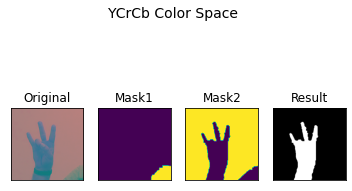

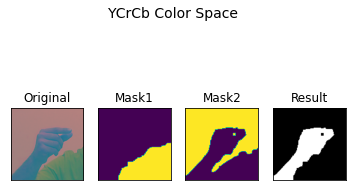

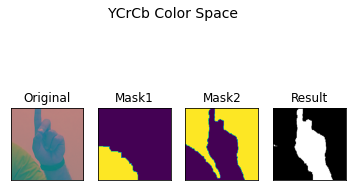

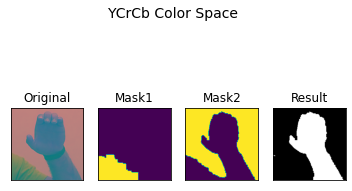

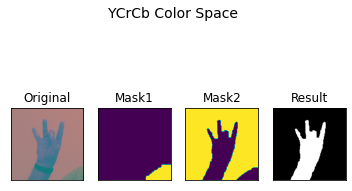

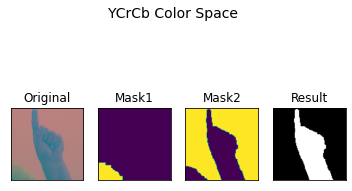

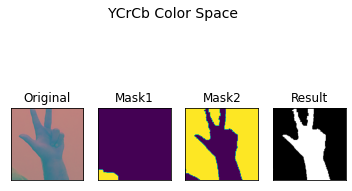

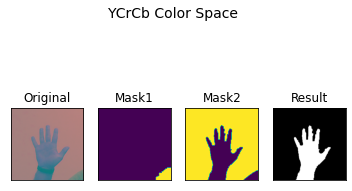

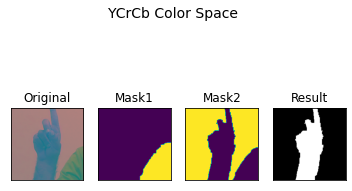

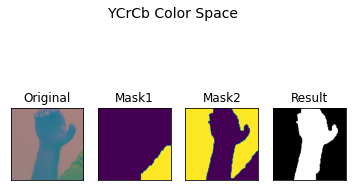

In [268]:
if __name__ == "__main__":

    image_path = "/content/drive/My Drive/Dataset"

    images = readImages(image_path)

    for i in images:
        #print("Original")
        #plt.imshow(i)  
        #plt.show()
        
        #print("the func")
        #plt.imshow(gray_world(i))
        #plt.show()
        #print("grayWorld")
        #gray = grayWorld(i)
        #plt.imshow((gray*255).astype(np.uint8))
        #plt.imshow(gray)
        #plt.show()

        #displayHistogram(i)
       # displayHistogram(cv2.cvtColor(gray, cv2.COLOR_BGR2YCrCb))
        '''plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2YCrCb))
        plt.show()'''
        secondThresholdYCRCB(i)

        